# Analyze FMCIB features for original and READII negative control CT images

This notebook is set up to use outputs from the `run_fmcib.ipynb` notebook.

Image features extracted from CT images cropped to a Gross Tumour Volume (GTV) undergo correlation analysis. Results are compared across READII negative control image types.

## Set up pixi environment kernel

1. Run the following commands in the terminal:

    ```bash
    $ pixi install

    $ pixi run make_kernel
    ```

2. In the `Select Kernel` menu at the top right of the notebook, select `Jupyter Kernel` as the source. 

3. Refresh the options and one called `readii-fmcib` should appear. Select this option.

## Imports

In [1]:
import itertools
import pandas as pd


from pathlib import Path
from readii.data.label import setPatientIdAsIndex
from readii.io.loaders import loadImageDatasetConfig, loadFeatureFilesFromImageTypes
from readii.io.writers import CorrelationWriter, PlotWriter
from readii.analyze import (
    getFeatureCorrelations, 
    getHorizontalSelfCorrelations, 
    getVerticalSelfCorrelations, 
    getCrossCorrelationMatrix, 
    plotCorrelationHeatmap,
    plotCorrelationHistogram
)


## Initialize dataset name and load config 

In [2]:
config = loadImageDatasetConfig("RADCURE", Path("config"))

DATASET_NAME = config["dataset_name"]
PAT_ID_PATTERN = config['patient_id_pattern']
NEG_CONTROL_REGIONS = config["negative_control_regions"]
NEG_CONTROL_TYPES = config["negative_control_types"]

# Get full list of image types to run FMCIB on
negative_control_list = [f"{negative_control[0]}_{negative_control[1]}" for negative_control in itertools.product(NEG_CONTROL_TYPES, NEG_CONTROL_REGIONS)]

## Set up data directories

In [3]:
correlations_dir = Path("results", DATASET_NAME, "analysis", "correlations")

# Set features input directory
features_dir = Path("results", DATASET_NAME, "fmcib_features")

# Make correlation results output directory
for combo in itertools.product([correlations_dir], ["matrix", "heatmap", "histogram"]):
    Path(*combo).mkdir(parents=True, exist_ok=True)

## Load all extracted feature sets

In [4]:
# Load the extracted feature data
# This makes a dictionary of feature sets, with the image type as the key
extracted_feature_sets = loadFeatureFilesFromImageTypes(extracted_feature_dir=features_dir,
                                                        image_types = (["original"] + negative_control_list), 
                                                        drop_labels = False)

# Run correlation analysis for each image type

In [5]:
def prepPatientIndex(feature_df:pd.DataFrame, file_path_column:str, pat_id_pattern:str) -> pd.DataFrame:
    """Extract patient ID from a DataFrame column of file paths based on a provided regex pattern."""
    # Get patient ID from file path name and make a column for this
    feature_df['patient_ID'] = feature_df[file_path_column].str.findall(pat_id_pattern)
    
    # Set the patient ID column as the index for the dataframe
    feature_df = setPatientIdAsIndex(feature_df, 'patient_ID')

    # Remove the image_path column
    feature_df.drop(labels="image_path", axis=1, inplace=True)

    return feature_df

In [6]:
# Set up writers for correlation and plots
corr_matrix_writer = CorrelationWriter(
    root_directory = correlations_dir / "matrix",
    filename_format = DATASET_NAME + "_{VerticalFeatureType}_{HorizontalFeatureType}_{CorrelationType}_correlations.csv",
    overwrite = False,
    create_dirs = True
)

heatmap_writer = PlotWriter(
    root_directory = correlations_dir / "heatmap",
    filename_format = "{ColorMap}/" + DATASET_NAME + "_{VerticalFeatureType}_{HorizontalFeatureType}_{CorrelationType}_heatmap.png",
    overwrite = True,
    create_dirs = True
)

histogram_writer = PlotWriter(
    root_directory = correlations_dir / "histogram",
    filename_format = DATASET_NAME + "_{VerticalFeatureType}_{HorizontalFeatureType}_{CorrelationType}_heatmap.png",
    overwrite = True,
    create_dirs = True
)

In [7]:
# Flag to make the original self-correlation plots only once
make_original_plots = True

# Name of the column used to extract the patient ID for a row of features
file_path_column = 'image_path'

# Correlation method to apply
correlation_method = "pearson"

# Colormap to use for plots
heatmap_cmap = "nipy_spectral"

# Get and set up the feature dataframe for the original features once
vertical_feature_type = "original"
vertical_features_df = prepPatientIndex(extracted_feature_sets[vertical_feature_type],
                                        file_path_column,
                                        PAT_ID_PATTERN)
vertical_feature_count = len(vertical_features_df)

# Iterate over each negative control feature set and perform correlation analysis
for horizontal_feature_type in ["shuffled_roi"]:
    corr_matrix_output_path = corr_matrix_writer.resolve_path(VerticalFeatureType=vertical_feature_type,
                                    HorizontalFeatureType=horizontal_feature_type,
                                    CorrelationType=correlation_method,
                                    ColorMap=heatmap_cmap)
    
    # Get extracted features for this image type, extract set the patient ID as the dataframe index, remove image_path column
    horizontal_features_df = prepPatientIndex(extracted_feature_sets[horizontal_feature_type], 
                                                file_path_column = file_path_column, 
                                                pat_id_pattern = PAT_ID_PATTERN)
    horizontal_feature_count = len(horizontal_features_df)
    
    # Load existing correlation matrix if it's available
    if corr_matrix_output_path.exists() and corr_matrix_output_path.is_file():
        print("Loading correlation matrix.")
        feature_correlation_df = pd.read_csv(corr_matrix_output_path, index_col=0)
    
    # Calculate the correlation matrix if the file doesn't exist
    else:
        print("Calculating correlation matrix.")
        # Calculate correlations between original image features and image type features
        feature_correlation_df = getFeatureCorrelations(vertical_features=vertical_features_df,
                                                            horizontal_features=horizontal_features_df,
                                                            vertical_feature_name=vertical_feature_type,
                                                            horizontal_feature_name=horizontal_feature_type,
                                                            method = correlation_method)
        # save out the correlation dataframe
        corr_matrix_writer.save(feature_correlation_df, 
                                VerticalFeatureType=vertical_feature_type,
                                HorizontalFeatureType=horizontal_feature_type,
                                CorrelationType=correlation_method,
                                ColorMap=heatmap_cmap)
    
    # Get subsections of the correlation matrix for plots
    horizontal_self_corr = getHorizontalSelfCorrelations(feature_correlation_df, horizontal_feature_count)
    cross_corr = getCrossCorrelationMatrix(feature_correlation_df, vertical_feature_count)
    
    vertical_heatmap_path = heatmap_writer.resolve_path(VerticalFeatureType=vertical_feature_type,
                                                        HorizontalFeatureType=vertical_feature_type,
                                                        CorrelationMethod=correlation_method,
                                                        ColorMap=heatmap_cmap)
    
    if not vertical_heatmap_path.exists() and vertical_heatmap_path.is_file():
        print(f"Making {vertical_feature_type} correlation figures.")
        vertical_self_corr = getVerticalSelfCorrelations(feature_correlation_df, vertical_feature_count)
        
        vertical_self_heatmap = plotCorrelationHeatmap(vertical_self_corr, 
                                                       diagonal=True, 
                                                       cmap=heatmap_cmap, 
                                                       xlabel=vertical_feature_type, 
                                                       ylabel=vertical_feature_type,
                                                       title=f"{correlation_method.capitalize()} Self Correlations", subtitle=f"{vertical_feature_type} vs. {vertical_feature_type}")
    
        
    


Loading correlation matrix.


In [15]:
horizontal_self = getHorizontalSelfCorrelations(feature_correlation_df.head(), num_horizontal_features = len())

TypeError: len() takes exactly one argument (0 given)

In [20]:
feature_correlation_df.filter(like='original', axis=0).filter(like='shuffled_roi', axis=1)

,pred_0_shuffled_roi,pred_1_shuffled_roi,pred_2_shuffled_roi,pred_3_shuffled_roi,pred_4_shuffled_roi,pred_5_shuffled_roi,pred_6_shuffled_roi,pred_7_shuffled_roi,pred_8_shuffled_roi,pred_9_shuffled_roi,...,pred_4086_shuffled_roi,pred_4087_shuffled_roi,pred_4088_shuffled_roi,pred_4089_shuffled_roi,pred_4090_shuffled_roi,pred_4091_shuffled_roi,pred_4092_shuffled_roi,pred_4093_shuffled_roi,pred_4094_shuffled_roi,pred_4095_shuffled_roi
pred_0_original,0.894515,-0.264361,-0.263969,-0.036482,-0.045445,0.303270,0.267183,0.194733,0.414993,-0.072687,...,0.231738,0.216651,0.316313,0.068566,0.180290,0.224918,0.068557,0.304362,0.225312,0.070597
pred_1_original,-0.180910,0.871239,0.107682,0.132274,0.223917,-0.111284,-0.260626,-0.232651,-0.322409,0.258137,...,-0.299274,-0.138796,-0.337291,0.226323,-0.198879,-0.293339,-0.026625,-0.045827,-0.306302,-0.125088
pred_2_original,-0.219521,0.019637,0.946490,-0.062655,-0.174245,-0.145266,-0.365884,-0.171187,-0.492887,0.267524,...,-0.331755,-0.193833,-0.382080,0.363082,-0.351716,0.185330,-0.400321,-0.220379,-0.205016,0.032959
pred_3_original,-0.161404,0.203331,-0.121218,0.875982,0.287580,0.400623,0.383982,0.379791,0.160261,0.132447,...,0.414604,0.395059,0.204401,-0.238203,0.413275,0.108392,0.301058,0.287402,0.299762,0.355010
pred_4_original,0.023627,0.252478,-0.104647,0.239736,0.857051,-0.035586,-0.061651,-0.163962,0.057509,-0.120683,...,-0.077534,0.035286,-0.090146,-0.012253,-0.029514,-0.241361,0.243085,0.066838,-0.135107,-0.077257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pred_4091_original,0.232300,-0.412011,0.142366,0.081947,-0.330106,0.428451,0.348950,0.522749,0.184499,0.165985,...,0.357809,0.288438,0.277415,0.075752,0.400169,0.935623,-0.133541,0.199060,0.568164,0.492852
pred_4092_original,0.040396,0.052059,-0.316986,0.228077,0.332647,0.163605,0.267581,0.289091,0.347787,0.071054,...,0.272506,0.306363,0.387850,-0.527939,0.329061,-0.089699,0.891929,0.442381,0.187733,0.114100
pred_4093_original,0.160546,-0.029136,-0.215999,0.329960,0.134178,0.598586,0.465006,0.624310,0.371969,0.293420,...,0.528202,0.682264,0.458022,-0.359372,0.600563,0.234151,0.526148,0.925449,0.530108,0.557610
pred_4094_original,0.110878,-0.335667,-0.222352,0.292901,-0.106356,0.816404,0.766759,0.822291,0.562210,0.193349,...,0.838146,0.663415,0.595996,-0.252815,0.873334,0.579257,0.298891,0.506016,0.984938,0.772134


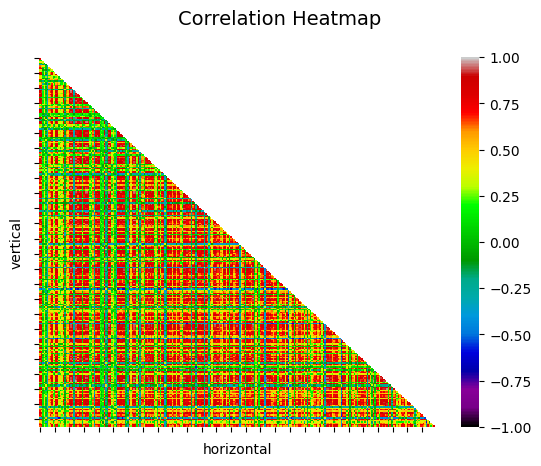

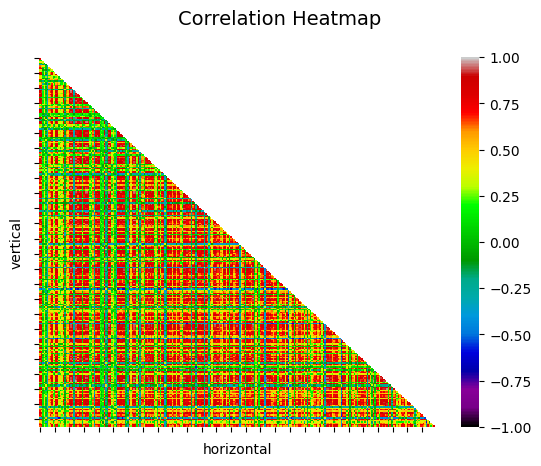

In [ ]:
plotCorrelationHeatmap(horizontal_self_corr, diagonal=True, cmap=heatmap_cmap, xlabel=horizontal_feature_type, ylabel=horizontal_feature_type)